<a href="https://colab.research.google.com/github/diascarolina/data-science-bootcamp/blob/main/modulo6/aulas_desafios_modulo6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Data Science Bootcamp

# Module 06 - Data Science in Finance

Notebook for the lessons and proposed challenges.

# Import Libraries

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

sns.set()

# Lesson 01

In [2]:
approved_clients_raw = pd.read_csv('https://github.com/diascarolina/data-science-bootcamp/blob/main/data/approved_clients.csv?raw=true')
client_records_raw = pd.read_csv('https://github.com/diascarolina/data-science-bootcamp/blob/main/data/client_record.csv?raw=true')

In [3]:
client_records_raw.head()

,id,gender,own_car,own_property,children_count,annual_income,income_type,education_type,marital_status,housing_type,age,own_cellphone,own_workphone,own_phone,own_email,occupation_type,family_size,years_working
0,5008804,m,1,1,0,427500.0,working,higher_education,civil_marriage,rented_apartment,33.0,1,1,0,0,others,2.0,12.4
1,5008805,m,1,1,0,427500.0,working,higher_education,civil_marriage,rented_apartment,33.0,1,1,0,0,others,2.0,12.4
2,5008806,m,1,1,0,112500.0,working,secondary,married,house_apartment,59.0,1,0,0,0,security,2.0,3.1
3,5008808,f,0,1,0,270000.0,commercial_associate,secondary,single,house_apartment,52.0,1,0,1,1,sales,1.0,8.4
4,5008809,f,0,1,0,270000.0,commercial_associate,secondary,single,house_apartment,52.0,1,0,1,1,sales,1.0,8.4


In [4]:
client_records_raw.shape

(438557, 18)

In [5]:
client_records_raw.id.value_counts()

7603224    2
7742853    2
7836711    2
7091721    2
7022327    2
          ..
5372264    1
6412652    1
6410605    1
6367602    1
6291456    1
Name: id, Length: 438510, dtype: int64

We can see that we have some repeated IDs.

In [6]:
client_records_raw.duplicated().sum()

0

This means that we don't have whole rows duplicated.

In [7]:
client_records_raw[client_records_raw.id.duplicated(keep = False)].shape

(94, 18)

So we have 94 problematic values (47 repeated ones). Let's save them.

In [8]:
repeated_ids = client_records_raw[client_records_raw.id.duplicated(keep = False)].id

In [9]:
client_records = client_records_raw.copy()
client_records = client_records.drop(repeated_ids.index)

In [10]:
client_records.shape

(438463, 18)

In [11]:
client_records.id.value_counts()

6293503    1
5166449    1
6210931    1
5174645    1
5170551    1
          ..
7410037    1
6357367    1
6375806    1
5683584    1
6291456    1
Name: id, Length: 438463, dtype: int64

Now we have only one ID per row.

Do we have null data?

In [12]:
print(f'Number of null values in client_records: {client_records.isnull().sum().sum()}')

Number of null values in client_records: 0


In [13]:
client_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438463 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               438463 non-null  int64  
 1   gender           438463 non-null  object 
 2   own_car          438463 non-null  int64  
 3   own_property     438463 non-null  int64  
 4   children_count   438463 non-null  int64  
 5   annual_income    438463 non-null  float64
 6   income_type      438463 non-null  object 
 7   education_type   438463 non-null  object 
 8   marital_status   438463 non-null  object 
 9   housing_type     438463 non-null  object 
 10  age              438463 non-null  float64
 11  own_cellphone    438463 non-null  int64  
 12  own_workphone    438463 non-null  int64  
 13  own_phone        438463 non-null  int64  
 14  own_email        438463 non-null  int64  
 15  occupation_type  438463 non-null  object 
 16  family_size      438463 non-null  floa

# Lesson 02

In [14]:
quantitative_variables = ['age', 'children_count', 'annual_income', 'years_working', 'family_size']

In [15]:
client_records[quantitative_variables].describe()

,age,children_count,annual_income,years_working,family_size
count,438463.000000,438463.000000,4.384630e+05,438463.000000,438463.000000
mean,43.834032,0.427384,1.875220e+05,-165.936036,2.194461
std,11.472815,0.724879,1.100832e+05,380.201131,0.897194
min,21.000000,0.000000,2.610000e+04,-1000.700000,1.000000
25%,34.000000,0.000000,1.215000e+05,1.000000,2.000000
50%,43.000000,0.000000,1.611000e+05,4.000000,2.000000
75%,53.000000,1.000000,2.250000e+05,8.500000,3.000000
max,69.000000,19.000000,6.750000e+06,48.000000,20.000000


Taking a look at the table above, how can someone have ```years_working``` equal to -1000.7?

In [16]:
client_records.query("years_working <= 0")[['years_working', 'income_type']].value_counts()

years_working  income_type         
-1000.7        pensioner               75314
 0.0           working                    26
               state_servant              11
               commercial_associate        7
dtype: int64

We see that all ```years_working == -1000.7``` are pensioners.

In [17]:
client_records.query("income_type == 'pensioner'")['income_type'].value_counts()

pensioner    75478
Name: income_type, dtype: int64

Almost all pensioners have ```years_working == -1000.7```.

In [18]:
client_records['years_working'] = client_records['years_working'].replace(-1000.7, -1)

In [19]:
client_records[quantitative_variables].describe()

,age,children_count,annual_income,years_working,family_size
count,438463.000000,438463.000000,4.384630e+05,438463.000000,438463.000000
mean,43.834032,0.427384,1.875220e+05,5.780633,2.194461
std,11.472815,0.724879,1.100832e+05,6.733151,0.897194
min,21.000000,0.000000,2.610000e+04,-1.000000,1.000000
25%,34.000000,0.000000,1.215000e+05,1.000000,2.000000
50%,43.000000,0.000000,1.611000e+05,4.000000,2.000000
75%,53.000000,1.000000,2.250000e+05,8.500000,3.000000
max,69.000000,19.000000,6.750000e+06,48.000000,20.000000


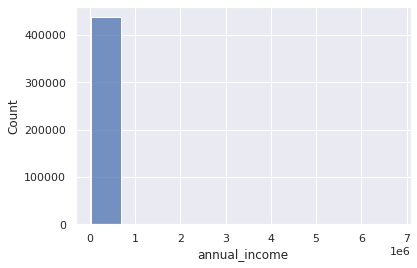

In [20]:
sns.histplot(data = client_records, x = 'annual_income', bins = 10)
plt.show()

Let's remove tha outliers.

In [21]:
annual_income_column = client_records['annual_income']
avg_annual_income = annual_income_column.mean()
std_annual_income = annual_income_column.std()

upper_limit = avg_annual_income + (2 * std_annual_income)
lower_limit = avg_annual_income - (2 * std_annual_income)

outlier_index = []
for index, value in annual_income_column.items():
    if value > upper_limit or value < lower_limit:
        outlier_index.append(index)

print(f'We have {len(outlier_index)} outliers in the annual income column.')

We have 12641 outliers in the annual income column.


In [22]:
client_records = client_records.drop(outlier_index)
client_records.shape

(425822, 18)

In [23]:
client_records[quantitative_variables].describe()

,age,children_count,annual_income,years_working,family_size
count,425822.000000,425822.000000,425822.000000,425822.000000,425822.000000
mean,43.838707,0.425314,176384.728083,5.744956,2.191683
std,11.525400,0.723577,75033.530551,6.736649,0.896300
min,21.000000,0.000000,26100.000000,-1.000000,1.000000
25%,34.000000,0.000000,117000.000000,1.000000,2.000000
50%,43.000000,0.000000,157500.000000,4.000000,2.000000
75%,53.000000,1.000000,225000.000000,8.500000,3.000000
max,69.000000,19.000000,405000.000000,48.000000,20.000000


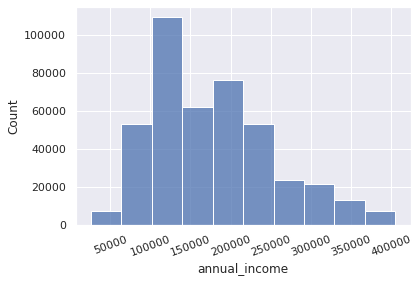

In [24]:
sns.histplot(data = client_records, x = 'annual_income', bins = 10)
plt.xticks(rotation = 20)
plt.show()

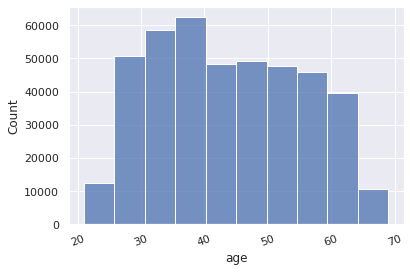

In [25]:
sns.histplot(data = client_records, x = 'age', bins = 10)
plt.xticks(rotation = 20)
plt.show()

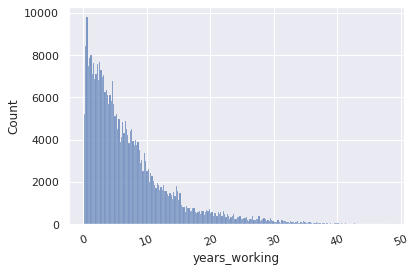

In [26]:
sns.histplot(data = client_records.query("years_working > 0"), x = 'years_working')
plt.xticks(rotation = 20)
plt.show()

In [27]:
client_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425822 entries, 2 to 438556
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               425822 non-null  int64  
 1   gender           425822 non-null  object 
 2   own_car          425822 non-null  int64  
 3   own_property     425822 non-null  int64  
 4   children_count   425822 non-null  int64  
 5   annual_income    425822 non-null  float64
 6   income_type      425822 non-null  object 
 7   education_type   425822 non-null  object 
 8   marital_status   425822 non-null  object 
 9   housing_type     425822 non-null  object 
 10  age              425822 non-null  float64
 11  own_cellphone    425822 non-null  int64  
 12  own_workphone    425822 non-null  int64  
 13  own_phone        425822 non-null  int64  
 14  own_email        425822 non-null  int64  
 15  occupation_type  425822 non-null  object 
 16  family_size      425822 non-null  floa

In [28]:
categorical_variables = ['gender', 'own_car', 'own_property', 'income_type',
                         'education_type', 'marital_status', 'housing_type',
                         'own_cellphone', 'own_workphone', 'own_phone', 'own_email',
                         'occupation_type']

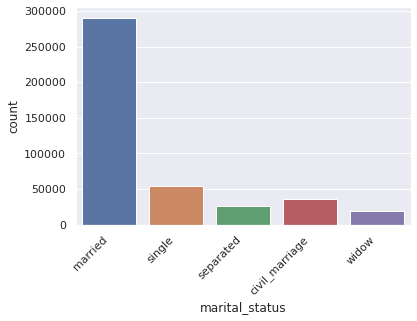

In [29]:
sns.countplot(data = client_records, x = 'marital_status')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

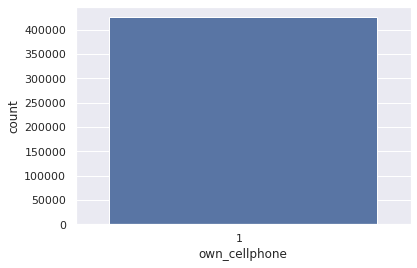

In [30]:
sns.countplot(data = client_records, x = 'own_cellphone')
plt.xticks(ha = 'right')
plt.show()

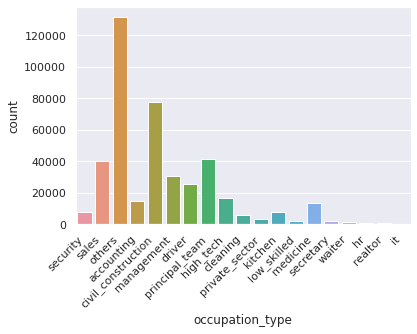

In [31]:
sns.countplot(data = client_records, x = 'occupation_type')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

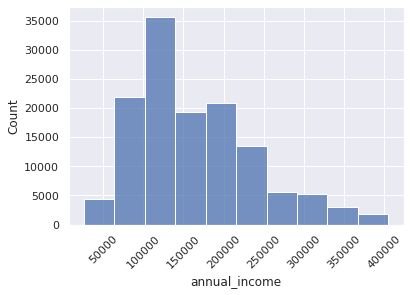

In [32]:
sns.histplot(data = client_records.query("occupation_type == 'others'"), x = 'annual_income', bins = 10)
plt.xticks(rotation = 45)
plt.show()

We have seen that the variable ``own_cellphone``` has only one alue, so it is not relevant for our future machine learning model.

Also, we will drop the gender variable in order to avoid a bias.

In [33]:
client_records_treatment1 = client_records.drop(['gender', 'own_cellphone'], axis = 1)

In [34]:
client_records_treatment1.shape

(425822, 16)

Let's update our categorical variables.

In [35]:
categorical_variables.remove('gender')
categorical_variables.remove('own_cellphone')

# Lesson 03

Let's now take a look at the approved clients.

In [36]:
approved_clients = approved_clients_raw.copy()

In [37]:
approved_clients.head()

,id,month,status
0,5001711,0,no_loan
1,5001711,-1,1-29days
2,5001711,-2,1-29days
3,5001711,-3,1-29days
4,5001712,0,paid_loan


In [38]:
approved_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   id      1048575 non-null  int64 
 1   month   1048575 non-null  int64 
 2   status  1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [39]:
approved_clients.id.value_counts().shape

(45985,)

In [40]:
client_records_treatment1.shape

(425822, 16)

In [41]:
# example of a client
approved_clients.query("id == 5001712")

,id,month,status
4,5001712,0,paid_loan
5,5001712,-1,paid_loan
6,5001712,-2,paid_loan
7,5001712,-3,paid_loan
8,5001712,-4,paid_loan
9,5001712,-5,paid_loan
10,5001712,-6,paid_loan
11,5001712,-7,paid_loan
12,5001712,-8,paid_loan
13,5001712,-9,1-29days


In [42]:
approved_clients.query("id == 5001711")

,id,month,status
0,5001711,0,no_loan
1,5001711,-1,1-29days
2,5001711,-2,1-29days
3,5001711,-3,1-29days


In [43]:
approved_clients.status.value_counts().index.to_list()

['paid_loan',
 '1-29days',
 'no_loan',
 '30-59days',
 '>150days',
 '60-89days',
 '90-119days',
 '120-149days']

## Creating Auxiliary Variables

In [44]:
# month in which the client's account was opened
approved_clients_by_id = approved_clients.copy()
approved_clients_by_id = approved_clients_by_id.groupby('id')
opening_series = approved_clients_by_id.apply(lambda x: min(x['month']))
opening_series.name = 'opening'
opening_series

id
5001711    -3
5001712   -18
5001713   -21
5001714   -14
5001715   -59
           ..
5150482   -28
5150483   -17
5150484   -12
5150485    -1
5150487   -29
Name: opening, Length: 45985, dtype: int64

In [45]:
approved_clients = approved_clients.merge(opening_series, on = 'id')
approved_clients.head()

,id,month,status,opening
0,5001711,0,no_loan,-3
1,5001711,-1,1-29days,-3
2,5001711,-2,1-29days,-3
3,5001711,-3,1-29days,-3
4,5001712,0,paid_loan,-18


In [46]:
last_registered_series = approved_clients_by_id.apply(lambda x: max(x['month']))
last_registered_series.name = 'final'
last_registered_series

id
5001711     0
5001712     0
5001713     0
5001714     0
5001715     0
           ..
5150482   -11
5150483     0
5150484     0
5150485     0
5150487     0
Name: final, Length: 45985, dtype: int64

In [47]:
approved_clients = approved_clients.merge(last_registered_series, on = 'id')
approved_clients.head()

,id,month,status,opening,final
0,5001711,0,no_loan,-3,0
1,5001711,-1,1-29days,-3,0
2,5001711,-2,1-29days,-3,0
3,5001711,-3,1-29days,-3,0
4,5001712,0,paid_loan,-18,0


In [48]:
# window of number of opening months
approved_clients['window'] = approved_clients['final'] - approved_clients['opening']
approved_clients.head()

,id,month,status,opening,final,window
0,5001711,0,no_loan,-3,0,3
1,5001711,-1,1-29days,-3,0,3
2,5001711,-2,1-29days,-3,0,3
3,5001711,-3,1-29days,-3,0,3
4,5001712,0,paid_loan,-18,0,18


In [49]:
# month on book (mob)
approved_clients['mob'] = approved_clients['month'] - approved_clients['opening']
approved_clients.head()

,id,month,status,opening,final,window,mob
0,5001711,0,no_loan,-3,0,3,3
1,5001711,-1,1-29days,-3,0,3,2
2,5001711,-2,1-29days,-3,0,3,1
3,5001711,-3,1-29days,-3,0,3,0
4,5001712,0,paid_loan,-18,0,18,18


In [50]:
approved_clients['status'].unique()

array(['no_loan', '1-29days', 'paid_loan', '30-59days', '60-89days',
       '90-119days', '120-149days', '>150days'], dtype=object)

In [51]:
status_dict = {
    'no_loan': 0,
    'paid_loan': 1,
    '1-29days': 2,
    '30-59days': 3,
    '60-89days': 4,
    '90-119days': 5,
    '120-149days': 6,
    '>150days': 7
}

approved_clients['status_int'] = approved_clients['status'].map(status_dict)

In [52]:
approved_clients.head()

,id,month,status,opening,final,window,mob,status_int
0,5001711,0,no_loan,-3,0,3,3,0
1,5001711,-1,1-29days,-3,0,3,2,2
2,5001711,-2,1-29days,-3,0,3,1,2
3,5001711,-3,1-29days,-3,0,3,0,2
4,5001712,0,paid_loan,-18,0,18,18,1


In [53]:
# approved_clients['bad'] = approved_clients.apply(lambda x: x['status_int'] > 3, axis = 1)
approved_clients['bad'] = approved_clients.apply(lambda x: 1 if x['status_int'] > 3 else 0, axis = 1)

In [54]:
approved_clients

,id,month,status,opening,final,window,mob,status_int,bad
0,5001711,0,no_loan,-3,0,3,3,0,0
1,5001711,-1,1-29days,-3,0,3,2,2,0
2,5001711,-2,1-29days,-3,0,3,1,2,0
3,5001711,-3,1-29days,-3,0,3,0,2,0
4,5001712,0,paid_loan,-18,0,18,18,1,0
...,...,...,...,...,...,...,...,...,...
1048570,5150487,-25,paid_loan,-29,0,29,4,1,0
1048571,5150487,-26,paid_loan,-29,0,29,3,1,0
1048572,5150487,-27,paid_loan,-29,0,29,2,1,0
1048573,5150487,-28,paid_loan,-29,0,29,1,1,0


## Vintage Analysis

In [55]:
approved_clients_unique_id = approved_clients[['id', 'opening', 'final', 'window']].groupby('id').apply(lambda x: x.iloc[0]).reset_index(drop = True)
approved_clients_unique_id

,id,opening,final,window
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59
...,...,...,...,...
45980,5150482,-28,-11,17
45981,5150483,-17,0,17
45982,5150484,-12,0,12
45983,5150485,-1,0,1


In [56]:
approved_clients_denominator = approved_clients_unique_id.groupby('opening').apply(lambda x: x['id'].count()).reset_index()
approved_clients_denominator.columns = ['opening', 'number_of_clients']
approved_clients_denominator

,opening,number_of_clients
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470
...,...,...
56,-4,874
57,-3,919
58,-2,771
59,-1,686


In [57]:
vintage = approved_clients.groupby(['opening', 'mob']).apply(lambda x: x['id'].count()).reset_index()
vintage.columns = ['opening', 'mob', 'number_of_clients']
vintage

,opening,mob,number_of_clients
0,-60,0,415
1,-60,1,414
2,-60,2,410
3,-60,3,408
4,-60,4,403
...,...,...,...
1886,-2,1,770
1887,-2,2,750
1888,-1,0,686
1889,-1,1,682


To explain the above table, let's look at the index 1886:
- opening -2 = 2 months ago
- mob 1 = account open for one month
- number_of_clients 770

So, two months ago we had 770 clients with accounts open for a period of one month.

In [58]:
vintage = pd.merge(vintage[['opening', 'mob']],
                   approved_clients_denominator,
                   on = ['opening'],
                   how = 'left')
vintage

,opening,mob,number_of_clients
0,-60,0,415
1,-60,1,415
2,-60,2,415
3,-60,3,415
4,-60,4,415
...,...,...,...
1886,-2,1,771
1887,-2,2,771
1888,-1,0,686
1889,-1,1,686


In [59]:
vintage['number_of_bad_payers'] = np.nan

for j in range(-60, 1):
    ls = []
    for i in range(0, 61):
        due = list(approved_clients.query("bad == 1 and mob == @i and opening == @j")['id'])
        ls.extend(due)
        vintage.loc[(vintage['mob'] == i) & (vintage['opening'] == j), 'number_of_bad_payers'] = len(set(ls))

vintage['bad_payers_rate'] = vintage['number_of_bad_payers'] / vintage['number_of_clients']
vintage

,opening,mob,number_of_clients,number_of_bad_payers,bad_payers_rate
0,-60,0,415,0.0,0.000000
1,-60,1,415,0.0,0.000000
2,-60,2,415,0.0,0.000000
3,-60,3,415,0.0,0.000000
4,-60,4,415,0.0,0.000000
...,...,...,...,...,...
1886,-2,1,771,0.0,0.000000
1887,-2,2,771,1.0,0.001297
1888,-1,0,686,0.0,0.000000
1889,-1,1,686,0.0,0.000000


In [60]:
vintage_pivot = vintage.pivot(index = 'opening',
                              columns = 'mob',
                              values = 'bad_payers_rate')

vintage_pivot

mob,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
opening,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-60,0.0,0.0,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,0.009639,0.012048,0.014458,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.019277,0.019277,0.019277,0.019277,0.021687,0.021687,0.021687,0.021687,0.024096,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.0,0.0,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,0.012315,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.022167,0.024631,0.024631,0.027094,0.027094,0.027094,0.027094,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,0.011364,0.013636,0.013636,0.013636,0.013636,0.013636,0.013636,0.015909,0.018182,0.018182,0.018182,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.0,0.0,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,0.007500,0.007500,0.010000,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.022500,0.022500,0.022500,0.022500,0.022500,0.022500,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.0,0.0,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,0.021277,0.025532,0.029787,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-4,0.0,0.0,0.000000,0.003432,0.003432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-3,0.0,0.0,0.001088,0.001088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2,0.0,0.0,0.001297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


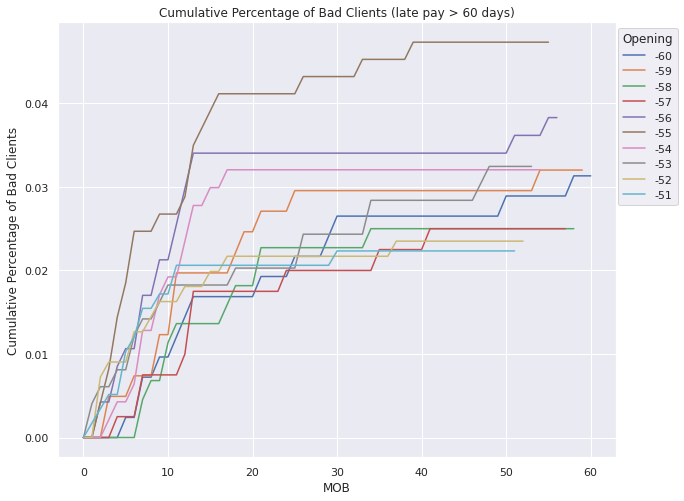

In [61]:
lst = [i for i in range(0, 61)]
vintage_pivot[lst].T.iloc[:, :10].plot(legend = True,
                                       grid = True,
                                       title = 'Cumulative Percentage of Bad Clients (late pay > 60 days)',
                                       figsize = (10, 8))

plt.xlabel('MOB')
plt.ylabel('Cumulative Percentage of Bad Clients')
plt.legend(bbox_to_anchor = (1.12, 1), title = 'Opening')
plt.show()

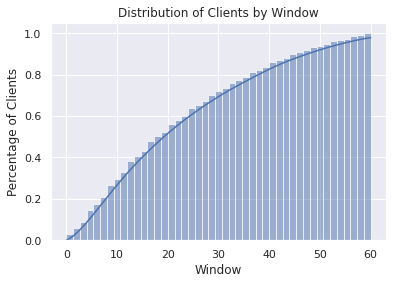

In [62]:
sns.histplot(data = approved_clients_unique_id,
             x = 'window',
             cumulative = True,
             stat = 'density',
             kde = True)
plt.title('Distribution of Clients by Window')
plt.xlabel('Window')
plt.ylabel('Percentage of Clients')
plt.show()

In [63]:
late_interval_dict = {
    'more_than_30_days': 3,
    'more_than_60_days': 4,
    'more_than_90_days': 5,
    'more_than_120_days': 6,
    'more_than_150_days': 7
}

In [64]:
for key, value in late_interval_dict.items():
    approved_clients[f'bad_{key}'] = approved_clients.apply(lambda x: 1 if x['status_int'] >= value else 0, axis = 1) 

In [65]:
approved_clients

,id,month,status,opening,final,window,mob,status_int,bad,bad_more_than_30_days,bad_more_than_60_days,bad_more_than_90_days,bad_more_than_120_days,bad_more_than_150_days
0,5001711,0,no_loan,-3,0,3,3,0,0,0,0,0,0,0
1,5001711,-1,1-29days,-3,0,3,2,2,0,0,0,0,0,0
2,5001711,-2,1-29days,-3,0,3,1,2,0,0,0,0,0,0
3,5001711,-3,1-29days,-3,0,3,0,2,0,0,0,0,0,0
4,5001712,0,paid_loan,-18,0,18,18,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,5150487,-25,paid_loan,-29,0,29,4,1,0,0,0,0,0,0
1048571,5150487,-26,paid_loan,-29,0,29,3,1,0,0,0,0,0,0
1048572,5150487,-27,paid_loan,-29,0,29,2,1,0,0,0,0,0,0
1048573,5150487,-28,paid_loan,-29,0,29,1,1,0,0,0,0,0,0


In [66]:
bad_rate_dict = {}
id_sum = len(set(approved_clients['id']))

for key in late_interval_dict.keys():
  min_bad = approved_clients.query(f'bad_{key} == 1').groupby('id')['mob'].min().reset_index()
  mob_bad_rate = pd.DataFrame({'mob':range(0,61), 'bad_rate': np.nan})
  lst = []
  for i in range(0,61):
      due = min_bad.query('mob == @i')['id'].to_list()
      lst.extend(due)
      mob_bad_rate.loc[mob_bad_rate['mob'] == i, 'bad_rate'] = len(set(lst)) / id_sum
  bad_rate_dict[key] = mob_bad_rate['bad_rate']

bad_rate = pd.DataFrame(bad_rate_dict)
bad_rate

,more_than_30_days,more_than_60_days,more_than_90_days,more_than_120_days,more_than_150_days
0,0.000304,0.000022,0.000022,0.000022,0.000022
1,0.011612,0.000174,0.000087,0.000087,0.000087
2,0.025878,0.001153,0.000196,0.000174,0.000174
3,0.036860,0.002240,0.000696,0.000304,0.000304
4,0.047385,0.003392,0.001044,0.000696,0.000348
...,...,...,...,...,...
56,0.116321,0.014483,0.007176,0.005263,0.004219
57,0.116321,0.014483,0.007176,0.005263,0.004219
58,0.116321,0.014505,0.007198,0.005284,0.004241
59,0.116321,0.014505,0.007198,0.005284,0.004241


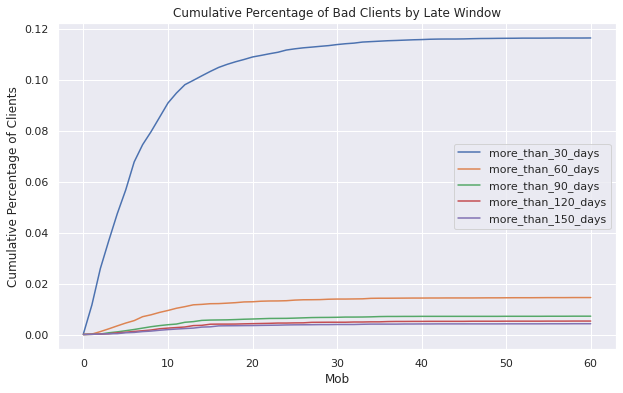

In [67]:
bad_rate.plot(grid = True,
              title = 'Cumulative Percentage of Bad Clients by Late Window',
              figsize = (10, 6))
plt.xlabel('Mob')
plt.ylabel('Cumulative Percentage of Clients')
plt.show()

## Defining the Target Variable

In [68]:
len(approved_clients.query('window >= 12').groupby('id').count().index)

30918

In [69]:
approved_clients_treatment1 = approved_clients.query('window >= 12').copy()
approved_clients_treatment1.shape

(943061, 14)

In [70]:
def verify(registers):
  status_list = registers['status'].to_list()
  if '60-89days' in status_list or '90-119days' in status_list or '120-149days' in status_list or '>150days' in status_list:
    return 1
  else:
    return 0
  
client_records_unique_id = pd.DataFrame(approved_clients_treatment1.groupby('id').apply(verify)).reset_index()
client_records_unique_id.columns = ['id', 'bad']
client_records_unique_id.head()

,id,bad
0,5001712,0
1,5001713,0
2,5001714,0
3,5001715,0
4,5001717,0


In [71]:
client_records_unique_id.shape

(30918, 2)

In [72]:
client_records_treatment1.shape

(425822, 16)

In [73]:
target_client_records = client_records_treatment1.merge(client_records_unique_id, on = 'id')
target_client_records.head()

,id,own_car,own_property,children_count,annual_income,income_type,education_type,marital_status,housing_type,age,own_workphone,own_phone,own_email,occupation_type,family_size,years_working,bad
0,5008806,1,1,0,112500.0,working,secondary,married,house_apartment,59.0,0,0,0,security,2.0,3.1,0
1,5008810,0,1,0,270000.0,commercial_associate,secondary,single,house_apartment,52.0,0,1,1,sales,1.0,8.4,0
2,5008811,0,1,0,270000.0,commercial_associate,secondary,single,house_apartment,52.0,0,1,1,sales,1.0,8.4,0
3,5008812,0,1,0,283500.0,pensioner,higher_education,separated,house_apartment,62.0,0,0,0,others,1.0,-1.0,0
4,5008813,0,1,0,283500.0,pensioner,higher_education,separated,house_apartment,62.0,0,0,0,others,1.0,-1.0,0


In [74]:
target_client_records['bad'].value_counts(normalize = True) * 100

0    97.726673
1     2.273327
Name: bad, dtype: float64

We can see that our data is pretty unbalanced.

# Lesson 04

In [75]:
!pip install scikit-learn==0.23.2 imbalanced-learn==0.7.0

In [76]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [77]:
binary_columns = ['own_car', 'own_property', 'own_workphone',
                  'own_phone', 'own_email']

In [78]:
non_binary_columns = ['income_type', 'education_type', 'marital_status',
                      'housing_type', 'occupation_type']

In [79]:
target_client_records = target_client_records[['id'] + quantitative_variables + binary_columns + non_binary_columns + ['bad']]

In [80]:
target_client_records.head()

,id,age,children_count,annual_income,years_working,family_size,own_car,own_property,own_workphone,own_phone,own_email,income_type,education_type,marital_status,housing_type,occupation_type,bad
0,5008806,59.0,0,112500.0,3.1,2.0,1,1,0,0,0,working,secondary,married,house_apartment,security,0
1,5008810,52.0,0,270000.0,8.4,1.0,0,1,0,1,1,commercial_associate,secondary,single,house_apartment,sales,0
2,5008811,52.0,0,270000.0,8.4,1.0,0,1,0,1,1,commercial_associate,secondary,single,house_apartment,sales,0
3,5008812,62.0,0,283500.0,-1.0,1.0,0,1,0,0,0,pensioner,higher_education,separated,house_apartment,others,0
4,5008813,62.0,0,283500.0,-1.0,1.0,0,1,0,0,0,pensioner,higher_education,separated,house_apartment,others,0


In [81]:
SEED = 1561651

def run_model(model, data):

    X = data.drop(['id', 'bad'], axis=1)
    y = data.drop('id', axis = 1)['bad']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = SEED)

    model.fit(X_train, y_train)

    prob_predic = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, prob_predic[:,1])
    print(f'AUC score: {auc}')
    
    good_data = np.sort(model.predict_proba(X_test)[:, 1])
    bad_data = np.sort(model.predict_proba(X_test)[:, 0])
    kstest = stats.ks_2samp(good_data, bad_data)
    print(f"KS: {kstest}")

    CM = plot_confusion_matrix(model,
                               X_test,
                               y_test,
                               values_format = '.0f',
                               display_labels = ['Good', 'Bad'])
    plt.grid(False)    
    plt.show(CM)

    prediction = model.predict(X_test)
    print('\nClassification Report')
    print(classification_report(y_test, prediction, zero_division = 0))

In [82]:
class Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, quantitative_variables, categorical_variables):
        self.quantitative_variables = quantitative_variables
        self.categorical_variables = categorical_variables
        self.encoder = OneHotEncoder()
        self.scaler = MinMaxScaler()

    def fit(self, X, y = None):
        self.encoder.fit(X[self.categorical_variables])
        self.scaler.fit(X[self.quantitative_variables])
        return self 

    def transform(self, X, y = None):
      X_categorical = pd.DataFrame(data = self.encoder.transform(X[self.categorical_variables]).toarray(),
                                  columns = self.encoder.get_feature_names(self.categorical_variables))
      
      X_quantitative = pd.DataFrame(data = self.scaler.transform(X[self.quantitative_variables]),
                                  columns = self.quantitative_variables)
      
      X = pd.concat([X_quantitative, X_categorical], axis = 1)

      return X

## Dummy Classifier

AUC score: 0.5
KS: Ks_2sampResult(statistic=1.0, pvalue=0.0)


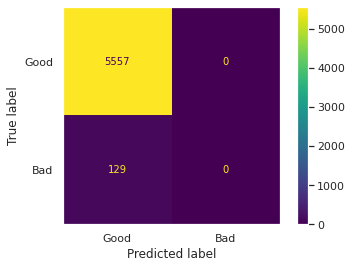


Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5557
           1       0.00      0.00      0.00       129

    accuracy                           0.98      5686
   macro avg       0.49      0.50      0.49      5686
weighted avg       0.96      0.98      0.97      5686



In [83]:
pipeline = Pipeline([('Transformer', Transformer(quantitative_variables, categorical_variables)),
                     ('Model', DummyClassifier(strategy = 'prior'))])   
run_model(pipeline, target_client_records)

## Logistic Regression

AUC score: 0.5847293657137516
KS: Ks_2sampResult(statistic=1.0, pvalue=0.0)


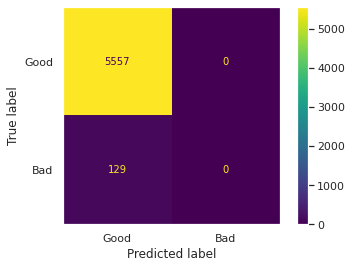


Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5557
           1       0.00      0.00      0.00       129

    accuracy                           0.98      5686
   macro avg       0.49      0.50      0.49      5686
weighted avg       0.96      0.98      0.97      5686



In [84]:
pipeline = Pipeline([('Transformer', Transformer(quantitative_variables, categorical_variables)),
                     ('Model', LogisticRegression(random_state = SEED, max_iter = 1000))])   
run_model(pipeline, target_client_records)

## Oversampling and Undersampling

AUC score: 0.5815990168137679
KS: Ks_2sampResult(statistic=0.1290889905029898, pvalue=1.09559025330554e-41)


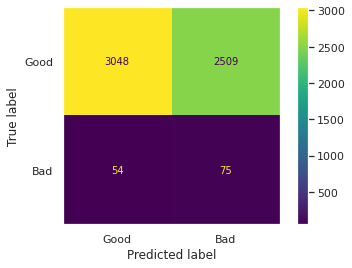


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.55      0.70      5557
           1       0.03      0.58      0.06       129

    accuracy                           0.55      5686
   macro avg       0.51      0.56      0.38      5686
weighted avg       0.96      0.55      0.69      5686



In [85]:
pipeline = Pipeline([('Transformer', Transformer(quantitative_variables, categorical_variables)),
                     ('Sampling', SMOTE(random_state = SEED)),
                     ('Model', LogisticRegression(random_state = SEED, max_iter = 1000))])   
run_model(pipeline, target_client_records)

AUC score: 0.8130676721726771
KS: Ks_2sampResult(statistic=0.979071403447063, pvalue=0.0)


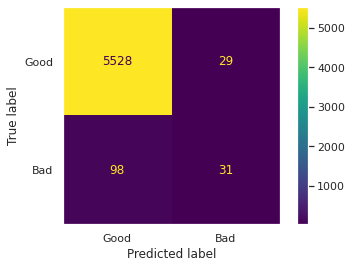


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5557
           1       0.52      0.24      0.33       129

    accuracy                           0.98      5686
   macro avg       0.75      0.62      0.66      5686
weighted avg       0.97      0.98      0.97      5686



In [89]:
pipeline = Pipeline([('Transformer', Transformer(quantitative_variables, categorical_variables)),
                     ('Model', RandomForestClassifier(random_state = SEED))])   
run_model(pipeline, target_client_records)

AUC score: 0.8419941047885691
KS: Ks_2sampResult(statistic=0.9651776292648611, pvalue=0.0)


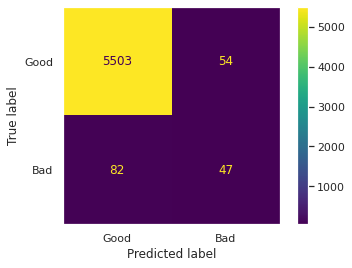


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5557
           1       0.47      0.36      0.41       129

    accuracy                           0.98      5686
   macro avg       0.73      0.68      0.70      5686
weighted avg       0.97      0.98      0.97      5686



In [88]:
pipeline = Pipeline([('Transformer', Transformer(quantitative_variables, categorical_variables)),
                     ('Sampling', SMOTE(random_state = SEED)),
                     ('Model', RandomForestClassifier(random_state = SEED))])   
run_model(pipeline, target_client_records)